In [1]:
#Get the Current Direction
import os 
cwd = os.getcwd()
cwd

'/home/human/WADDAH/filtered_data-20220316T182212Z-001/filtered_data'

## Necessary libraries

In [125]:
from pandas.io.pytables import read_hdf
import os
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from pandas import read_hdf # For dataframes
from pandas import DataFrame # For dataframes
from numpy import ravel # For matrices
import matplotlib.pyplot as plt # For plotting data
import seaborn as sns # For plotting data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
from sklearn.ensemble import RandomForestRegressor as RF
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from numpy import absolute, mean, std
from IPython.core.pylabtools import figsize
# Model baseline architecture
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Input, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.constraints import max_norm
from numpy import array
from numpy.random import uniform
from numpy import hstack
from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')
#Get the Current Direction 
cwd = os.getcwd()
cwd


'/home/human/WADDAH/filtered_data-20220316T182212Z-001/filtered_data'

## Necessary functions

In [347]:
#----------------------------------------Dataset Functions--------------------------------------------------#
# Load the dataset 
def read_data( path, n_files=10):
  df =[]
  os.chdir(path)
  for i, file in enumerate(os.listdir(path)):
    if file.endswith('.hdf5') and i<n_files:
      file_path = f'{path}/{file}'
      data = pd.read_hdf(file_path)
      df.append(data)
  df = pd.concat(df)
  return df

# plot the loaded dataset (input:EMG or output:FORCE)
def plot_data(title, df):
    assert title == 'EMG' or title == 'FORCE', f'title: {title} is not allowed, title should be either FORCE or EMG'
  # The raw EMG data are measured as ADC values
  # to calculate the measured EMG in mV, we multipy each ADC value by 25/(2^12)
    config = {title:{'rows':df.shape[1]//2 if df.shape[1]%2==0 else df.shape[1]//2+1, 'cols':2,'metric':'mv' if title=='EMG' else 'N'}}
    r, c = config[title]['rows'], config[title]['cols']
    metric = config[title]['metric']
    figure, ax = plt.subplots(r,c, figsize=(20,20)) 
    for i, col in enumerate(df.columns):  
        gt = list(df[col]*25/(2**12) if title=='EMG' else df[col]) 
        #--TODO-- change the df for FORCE case after checking for calculating the forces
        ax[i//c,i%c].set_title(f'{title} {i+1}')
        ax[i//c,i%c].set(xlabel='Samples', ylabel= metric)
        ax[i//c,i%c].plot(gt)
    figure.tight_layout()
    return plt

# Creating a dataframe from inpdepended features (EMG signals) and depended y target values (FORCE measurements)
def X_y_data(df):
    data = df.copy()
    n_features = data.columns.get_loc('FORCE_1')
    n_forces = 10
    last_force = n_features + n_forces
    features = data.columns[:n_features]
    X = data[features]
    out = data.columns[n_features:last_force]
    y = data[out]
    X_y_df = pd.concat([X,y], axis=1)
    return X, y, X_y_df

# Data cleaning from infs and NaNs
def remove_nans(df):
    df = df.replace([np.inf, -np.inf],np.nan).fillna(df.mean())
    mat = np.array([df])
    print(f'nan values: {np.any(np.isnan(mat))}')
    print(f'all values are finite: {np.all(np.isfinite(mat))}')
    X, y, df = X_y_data(df)
    return X,y,df
#----------------------------------------BUILDING ML MLODELS--------------------------------------------------#
#Design r2_score as a metric in keras
def r2_keras(y_true, y_hat):
    from keras import backend as K
    RSS =  K.sum(K.square( y_true - y_hat ))
    TSS = K.sum(K.square( y_true - K.mean(y_true) ))
    return ( 1. - (RSS/TSS) )

## RNN Model building
def make_rnn(X_train,y_train):
    model = Sequential()
    model.add(LSTM(64, input_shape = (X_train.shape[1],X_train.shape[-1]),return_sequences=True, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(20,return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse', r2_keras])
    model.summary()
    return model

# ANN model building (MLP)
def make_ANN( Factor = 2, input_n = X.shape[1],sample_n= X.shape[0], kernel_init = 'he_uniform', activation='relu', final_ac='linear'):
    hidden_n =int(sample_n/(Factor*(input_n+1)))
    input_ = Input(shape=(input_n,))
    Drop_rate = 0.05
    dense = Dense(input_n, activation = activation)
    x = dense(input_)
    x = Dense(hidden_n, activation = activation)(x)
    #x1 = Dense(hidden_n, activation = activation)(x)
    output_ = Dense(10,activation=final_ac)(x)
    model = keras.Model(inputs = input_, outputs = output_, name = 'MLP')
    model.compile(loss = 'mae', optimizer = 'adam', metrics=['mae', r2_keras])
    return model

# Random Forest model pipeline
def make_RF_pipe(model):
    RF_pipe = Pipeline(
    [
        ('Scaler',StandardScaler()),
        ('Selector',VarianceThreshold()),
        #('Poly_feature', polynomial_feature),
        ('Estimator',RF(n_jobs = -1,bootstrap = False,max_depth = None,max_features = 'sqrt',min_samples_split = 2,min_samples_leaf = 1, n_estimators=200))
    ], verbose = True
    )
    return RF_pipe
#----------------------------------------MODEL TRAINING AND VALIDATION-------------------------------------------#

## model training
def train_model(model, X_train, y_train, X_test, y_test, n_epochs, batch_size):
    from keras.callbacks import EarlyStopping
    callback = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
    history = model.fit(
            X_train, y_train, epochs = n_epochs,batch_size = batch_size, 
                        validation_data = (X_test, y_test), callbacks = [callback], verbose=1
                    )
    return history

# Convert dataframe to numpy array element for using in calculating mse error
def df2arr(df):
    return np.array(df)

# print the mse error for each output column of the Multi-output regressor 
def print_error(y_test, y_pred):
    err_list = []
    for i in range(y_test.shape[1]):
        err_list.append(mean_squared_error(y_test.iloc[:,i],y_pred[:,i]))
    for i,error in enumerate(err_list):
        print(f'FORCE {i+1} MSE: {error}')
    return err_list
def plot_err_bar(y_test, y_pred, model_name):
    error = print_error(y_test, y_pred)
    langs = [f'FORCE {i+1}' for i in range(y_test.shape[1])]
    figure = plt.figure(figsize=(10,5))
    ax = figure.add_axes([0,0,1,1])
    ax.bar(langs, error)
    ax.set_ylabel('Mean Squared Error')
    ax.set_title(f'{model_name} Model evaluation: mean squared error for each predicted force of the validation dataset')
    plt.show()

# plot the y_pred compared to y_test 
def plot_prediction_1(y_test, y_pred):
    t = range(len(y_test))
    plt.scatter(t,y_pred,s=6,label = 'Prediction')
    plt.plot(t,y_test,'r.',label = 'Ground Truth')
    plt.title('GT vs Prediction')
    plt.xlabel('samples')
    plt.ylabel('Standard Scaled Forces')
    plt.legend(loc = 'best')
    plt.show()
def plot_prediction(y_test, y_pred, mse):
    t = range(len(y_test))
    figure, ax = plt.subplots(5,2,figsize=(15,15), squeeze = True)
    for i, err in zip(range(y_test.shape[1]),mse):
        ax[i//2, i%2].plot(t, y_pred[:,i], 'r.', label='Prediction')
        ax[i//2, i%2].plot(t,y_test.iloc[:,i],'b.',label='Ground Truth')
        ax[i//2, i%2].set_title(f'FORCE {i+1} GT vs Pred: MSE = {round(err,2)}', fontsize = 14)
        ax[i//2, i%2].set_ylabel('Standard Scaled Forces')
        ax[i//2, i%2].legend(loc = 'upper left',frameon=False, fontsize=12)
#         ax[i//2, i%2].text(500,3,f'MSE: {round(err,2)}', fontsize = 12)
    plt.tight_layout() 
    
# evaluate and plot the model prediction using plot prediction function
def plot_predict_res(model, X_test, y_test, n_samples):
    y_pred = model.predict(X_test)
    score = r2_score(y_test,y_pred)
    mse = []
    for i in range(y_test.shape[1]):
        mse.append(mean_squared_error(y_test.iloc[:,i], y_pred[:,i]))
    print('Model Performance:')
    print('R2 Score = %.2f'%score)
    plot_prediction(y_test.iloc[:n_samples,:], y_pred[:n_samples,:],mse)
    return y_pred

## visualizing the model validation results (mae, score)
def plot_model_evaluation(model, metric = 'mae', val_metric = 'val_mae'):
    plt.plot(model.history[metric], label = metric)
    plt.plot(model.history[val_metric], label = val_metric)
    plt.title('model loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'loss: {metric}')
    plt.legend()
    plt.show()
    plt.plot(model.history['r2_keras'], label = 'r2_score')
    plt.plot(model.history['val_r2_keras'], label = 'val_r2_score')
    plt.title('model score')
    plt.xlabel('Epochs')
    plt.ylabel('r2_score')
    plt.legend()
    plt.show()
    return model



## Load dataset

In [119]:
path_raw_data = cwd
read_files = 5
df_data = read_data(path_raw_data, read_files)
df_data.head()

,EMG_1,EMG_2,EMG_3,EMG_4,EMG_5,EMG_6,EMG_7,EMG_8,EMG_9,EMG_10,...,FORCE_10,FORCE_MVC,TRAJ_1,TRAJ_2,TRAJ_3,TRAJ_4,type,subject,trajectory,date_time
-0.071430,1.406034,1.413926,1.318121,1.359027,1.526400,0.315886,1.061131,1.452470,1.187080,1.343820,...,-71.49,477.76,0.0,0.0,0.0,0.0,emg_force,3,repeats_short,2018-05-11 11:34:34.187
-0.071235,9.587618,8.898107,7.785308,8.122521,8.474587,4.022166,6.574807,8.375997,6.867630,8.125102,...,-71.49,477.76,0.0,0.0,0.0,0.0,emg_force,3,repeats_short,2018-05-11 11:34:34.187
-0.071040,15.950627,14.710692,13.039104,13.463862,14.032688,6.908494,11.066432,13.862889,11.203378,13.452462,...,-71.49,477.76,0.0,0.0,0.0,0.0,emg_force,3,repeats_short,2018-05-11 11:34:34.187
-0.070845,19.115962,17.581992,15.992105,16.222824,17.015309,8.312272,13.603078,16.740197,13.199876,16.163327,...,-71.49,477.76,0.0,0.0,0.0,0.0,emg_force,3,repeats_short,2018-05-11 11:34:34.187
-0.070650,18.561474,17.026889,15.978015,15.840382,16.777321,7.923569,13.590570,16.435045,12.526277,15.727473,...,-71.49,477.76,0.0,0.0,0.0,0.0,emg_force,3,repeats_short,2018-05-11 11:34:34.187


## Visualize data : EMG or Force - plot_data()

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

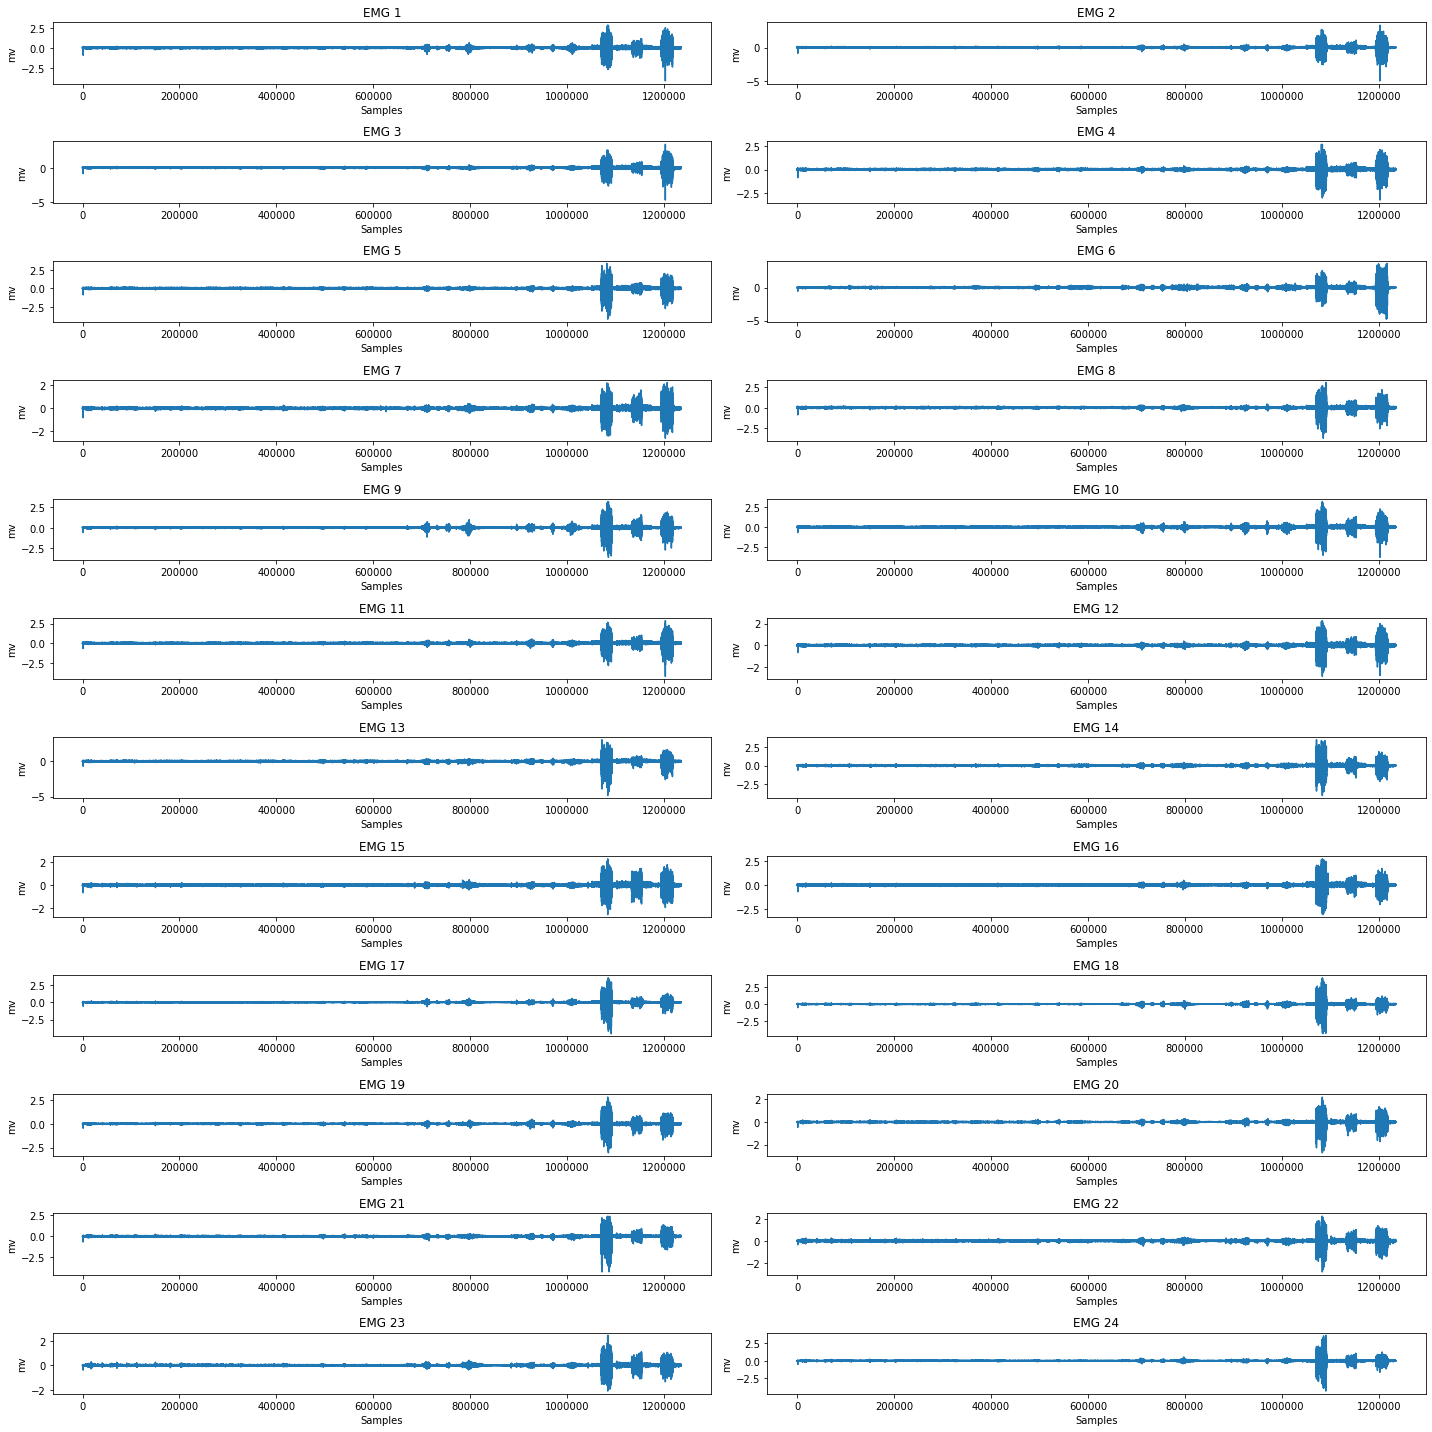

In [333]:
plot_data("EMG", df_data.iloc[:,:24])

## Defining the X-y Data profile


In [121]:
X, y, df = X_y_data(df_data)
print(ddf.columns)
print(ddf.shape)
print(n.shape)
print(m.shape)


Index(['EMG_1', 'EMG_2', 'EMG_3', 'EMG_4', 'EMG_5', 'EMG_6', 'EMG_7', 'EMG_8',
       'EMG_9', 'EMG_10', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15',
       'EMG_16', 'EMG_17', 'EMG_18', 'EMG_19', 'EMG_20', 'EMG_21', 'EMG_22',
       'EMG_23', 'EMG_24', 'FORCE_1', 'FORCE_2', 'FORCE_3', 'FORCE_4',
       'FORCE_5', 'FORCE_6', 'FORCE_7', 'FORCE_8', 'FORCE_9', 'FORCE_10'],
      dtype='object')
(1234944, 34)
(1234944, 10)
(1234944, 24)


## Data preprocessing

Data Cleaning from NaNs and infinite numbers

In [122]:
X, y, df = remove_nans(df)

nan values: False
all values are finite: True


## Data splitting into train - test

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y, 
    test_size=0.1,
    random_state=0,shuffle = False) #TODO Change shuffle to True (the default value), CHECK for stratify
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1111449, 24)
X_test: (123495, 24)
y_train: (1111449, 10)
y_test: (123495, 10)


<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

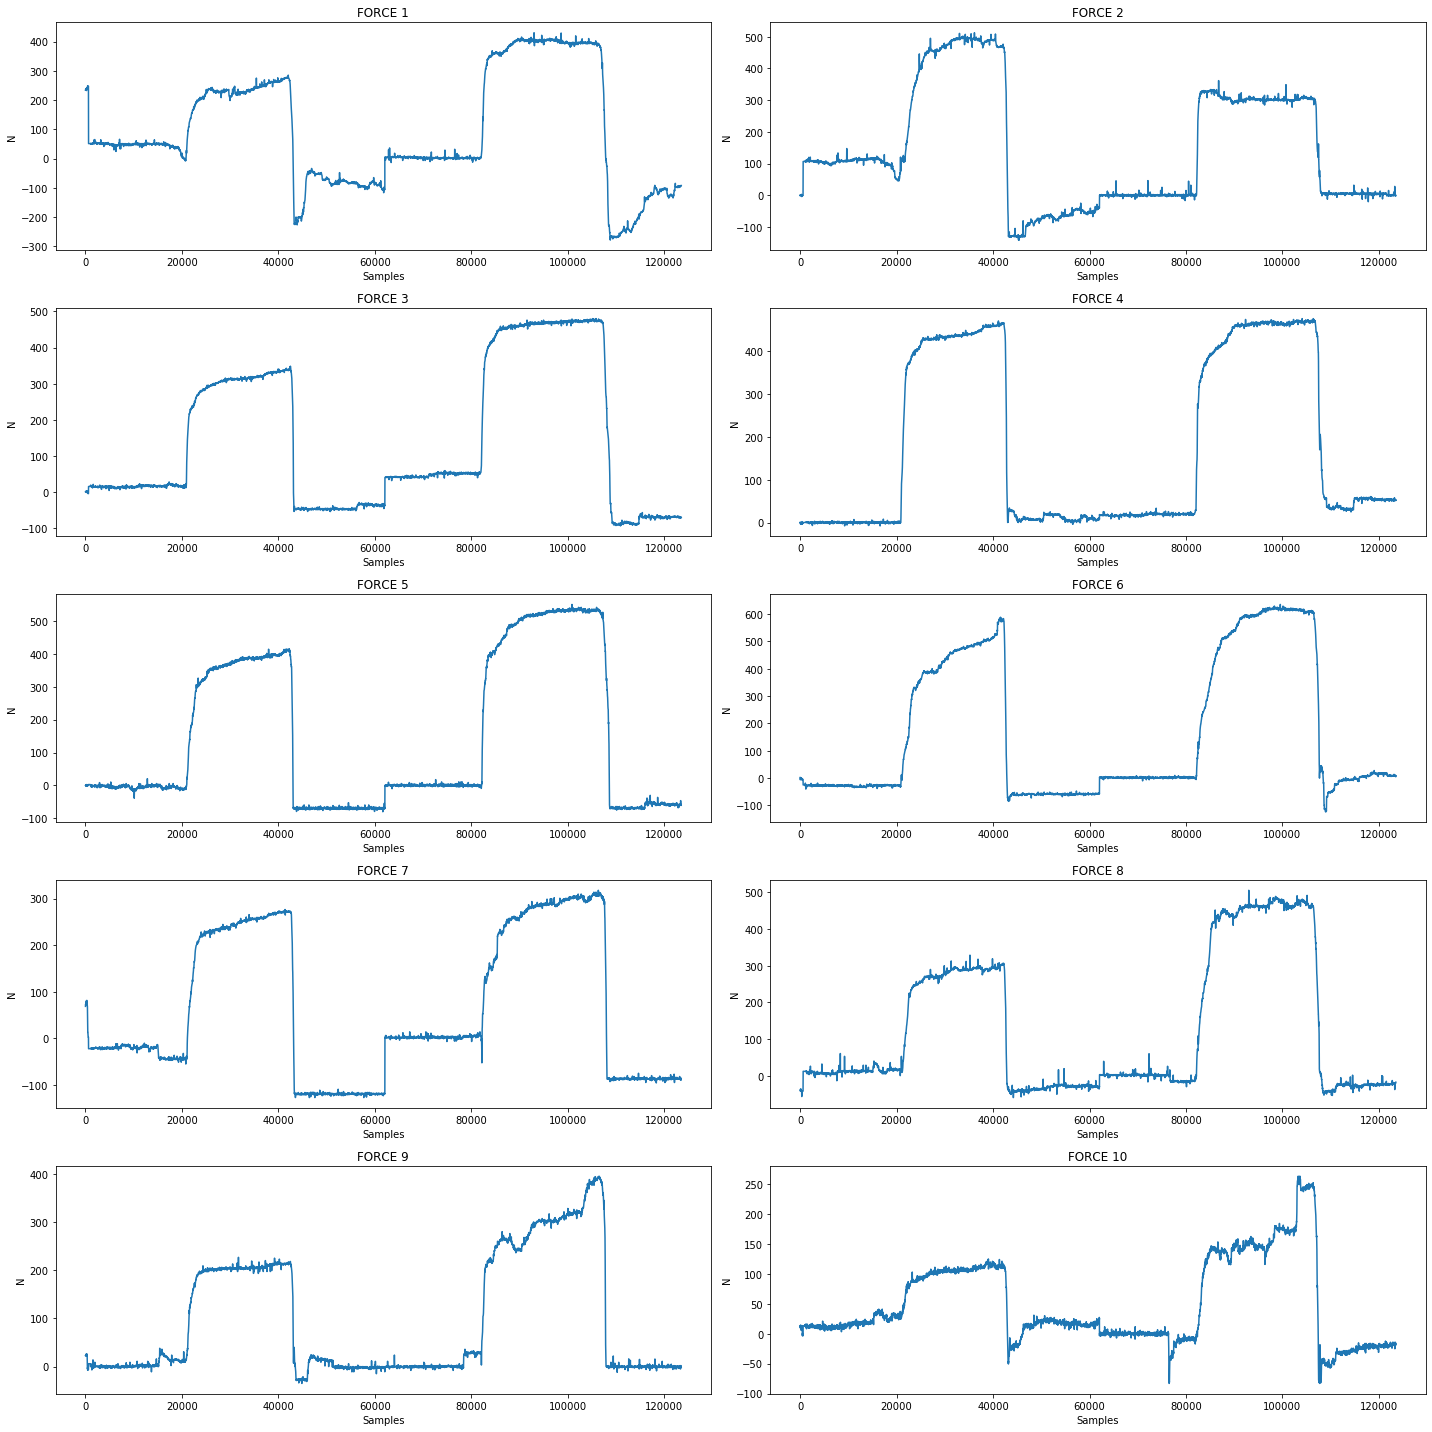

In [334]:
# Visualize force test data
plot_data('FORCE', y_test.iloc[:,:])

##  Random forest pipeline

In [126]:
RF_pipe = make_RF_pipe(RF)
RF_pipe

Pipeline(steps=[('Scaler', StandardScaler()), ('Selector', VarianceThreshold()),
                ('Estimator',
                 RandomForestRegressor(bootstrap=False, max_features='sqrt',
                                       n_estimators=200, n_jobs=-1))],
         verbose=True)

In [127]:
# Model training:
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Selector', 'Estimator', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Selector__threshold', 'Estimator__bootstrap', 'Estimator__ccp_alpha', 'Estimator__criterion', 'Estimator__max_depth', 'Estimator__max_features', 'Estimator__max_leaf_nodes', 'Estimator__max_samples', 'Estimator__min_impurity_decrease', 'Estimator__min_samples_leaf', 'Estimator__min_samples_split', 'Estimator__min_weight_fraction_leaf', 'Estimator__n_estimators', 'Estimator__n_jobs', 'Estimator__oob_score', 'Estimator__random_state', 'Estimator__verbose', 'Estimator__warm_start'])

In [128]:
# RF_pipe.fit(X_train, y_train)

In [129]:
# print(f'Training set score: {RF_pipe.score(X_train, y_train)}')
# print(f'Test set score: {RF_pipe.score(X_test, y_test)}')

## Building an Aartificial neural network (ANN)

In [ ]:
# data rescaling
X1, y1 = pd.DataFrame(StandardScaler().fit_transform(X)), pd.DataFrame(StandardScaler().fit_transform(y))

In [217]:
#train - test splitting 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size =0.2, random_state=0)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(987955, 24)
(246989, 24)
(1111449, 10)
(123495, 10)


In [223]:
ANN = make_ANN()

In [224]:
history_mlp = train_model(ANN, X_train1, y_train1, X_test1, y_test1, 100, 512)


Epoch 1/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.3417 - mae: 0.3417 - r2_keras: 0.6470 - val_loss: 0.3167 - val_mae: 0.3167 - val_r2_keras: 0.6884
Epoch 2/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.3077 - mae: 0.3077 - r2_keras: 0.7080 - val_loss: 0.3037 - val_mae: 0.3037 - val_r2_keras: 0.7137
Epoch 3/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.2985 - mae: 0.2985 - r2_keras: 0.7221 - val_loss: 0.2958 - val_mae: 0.2958 - val_r2_keras: 0.7223
Epoch 4/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.2931 - mae: 0.2931 - r2_keras: 0.7310 - val_loss: 0.2928 - val_mae: 0.2928 - val_r2_keras: 0.7325
Epoch 5/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.2895 - mae: 0.2895 - r2_keras: 0.7373 - val_loss: 0.2964 - val_mae: 0.2964 - val_r2_keras: 0.7363
Epoch 6/100
1930/1930 [==============================] - 8s 4ms/step - loss: 0.2867 - mae: 0.2867 - r2_keras: 0.742

### Evaluating the model on the validation dataset


FORCE 1 MSE: 0.2885986034737193
FORCE 2 MSE: 0.2799490470689174
FORCE 3 MSE: 0.3376765292455505
FORCE 4 MSE: 0.2322497604694291
FORCE 5 MSE: 0.28762668967756244
FORCE 6 MSE: 0.10906124056476008
FORCE 7 MSE: 0.2662411765061153
FORCE 8 MSE: 0.05161173014692525
FORCE 9 MSE: 0.2707302877078248
FORCE 10 MSE: 0.17748613808077765


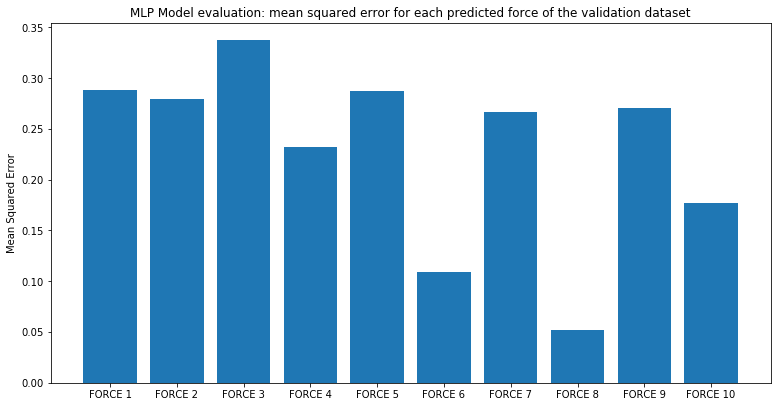

In [349]:
ypred = ANN.predict(X_test1)
plot_err_bar(y_test1, ypred,'MLP')

In [226]:
print(X1.shape)
print(y1.shape)

(1234944, 24)
(1234944, 10)


Model Performance:
R2 Score = 0.89


array([[-0.536855  ,  0.24468376,  0.3591203 , ..., -0.14354962,
         1.0071892 ,  0.5216484 ],
       [-0.5389597 ,  0.29285282,  0.35369125, ..., -0.1337457 ,
         1.0922595 ,  0.6388525 ],
       [-0.5241155 ,  0.27201688,  0.2902688 , ..., -0.1454622 ,
         1.0646    ,  0.69246966],
       ...,
       [-0.6639054 , -0.15283516, -0.9977753 , ..., -0.6007037 ,
        -0.31755906, -0.824459  ],
       [-0.87754744, -0.23298952, -1.2211498 , ..., -0.63582885,
        -0.45907414, -0.92487806],
       [-1.0105819 , -0.3757448 , -1.2814523 , ..., -0.5502141 ,
        -0.568217  , -0.85791576]], dtype=float32)

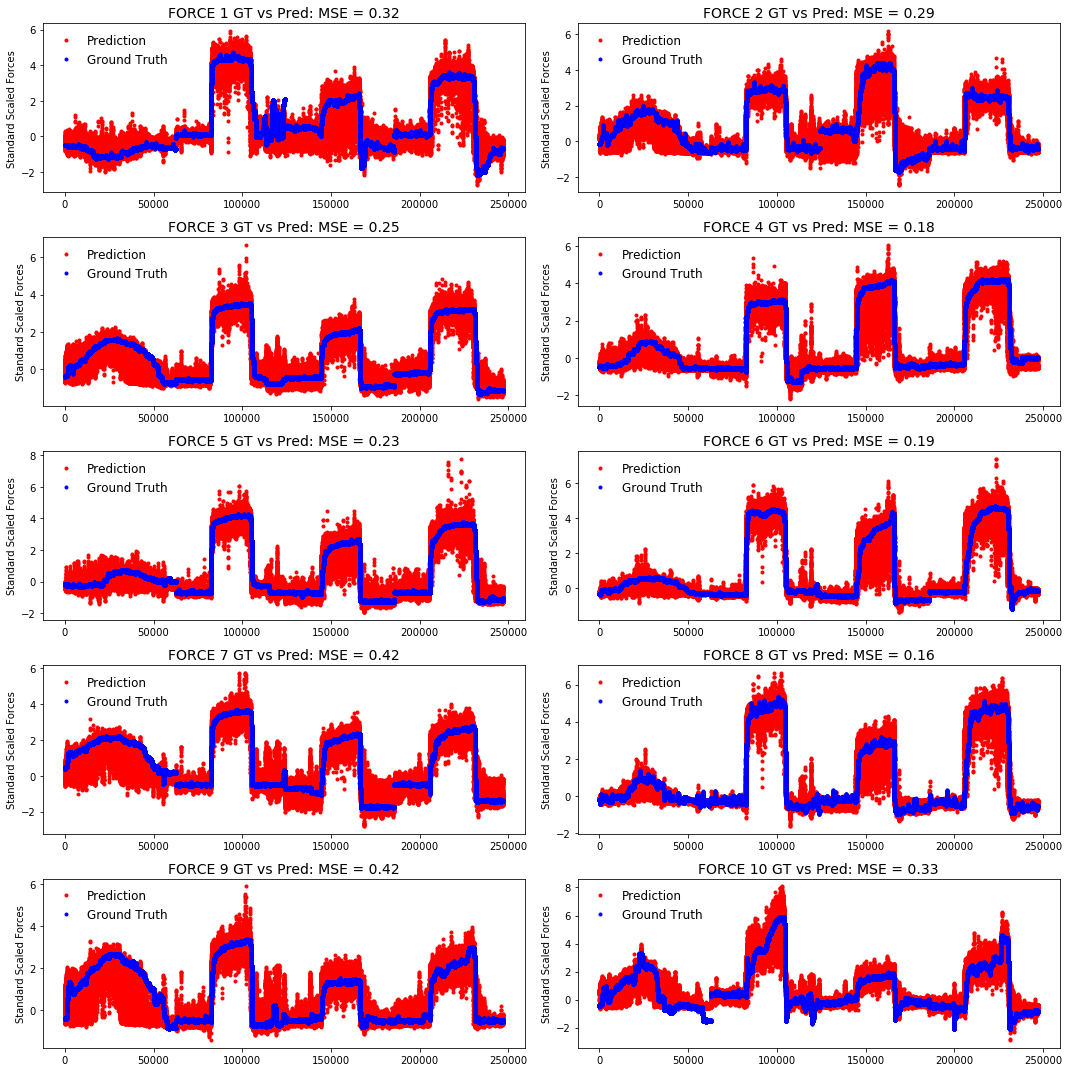

In [350]:
#plot the resulting predictions with the MSE for a sample of dataset after evaluation (MSE here is different )
X2_, y2_ = X1.iloc[len(X_train1):,:], y1.iloc[len(y_train1):,:]
plot_predict_res(ANN, X2_, y2_, n_samples=len(y_test1))

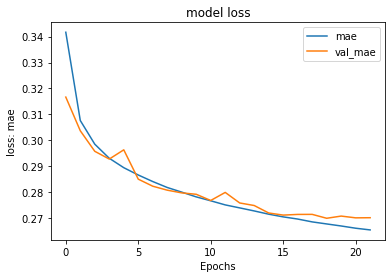

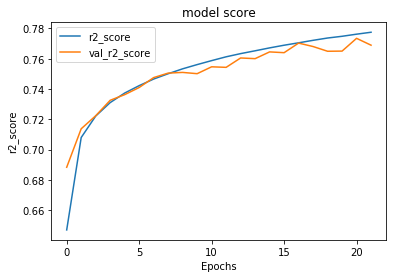

In [284]:
plot_model_evaluation(history_mlp, metric = 'mae', val_metric = 'val_mae')

## Recurrent Neural Network

In [285]:
print(X1.shape)
print(y1.shape)
Xr = np.array(X1).reshape(X1.shape[0],X1.shape[1],1)
in_dim = (Xr.shape[1], Xr.shape[2])
out_dim = y1.shape[1]
print(f'in: {in_dim} , out: {out_dim}')

(1234944, 24)
(1234944, 10)
in: (24, 1) , out: 10


In [286]:
Xr_train, Xr_test, yr_train, yr_test=train_test_split(Xr, y1, test_size =0.2, random_state=0)

In [287]:
RNN = make_rnn(Xr_train, yr_train)
history = train_model(RNN, Xr_train, yr_train, Xr_test, yr_test, 100, 512)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 24, 64)            16896     
                                                                 
 dropout_25 (Dropout)        (None, 24, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 20)                6800      
                                                                 
 dropout_26 (Dropout)        (None, 20)                0         
                                                                 
 dense_57 (Dense)            (None, 10)                210       
                                                                 
Total params: 23,906
Trainable params: 23,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1930/1930 [==========================

FORCE 1 MSE: 0.35083848208787355
FORCE 2 MSE: 0.3196921041838448
FORCE 3 MSE: 0.37296994843457076
FORCE 4 MSE: 0.2601802324399107
FORCE 5 MSE: 0.36024928479163953
FORCE 6 MSE: 0.14580872375809859
FORCE 7 MSE: 0.33316033145978513
FORCE 8 MSE: 0.08617638636747502
FORCE 9 MSE: 0.3032652946974945
FORCE 10 MSE: 0.25232755620413777


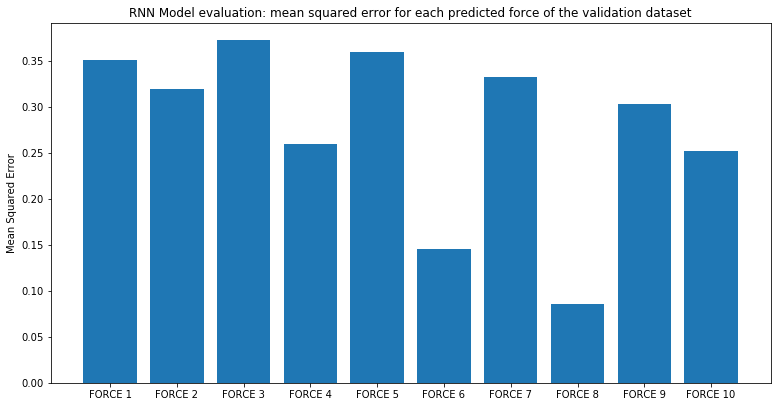

In [348]:
y_pred = RNN.predict(Xr_test)
# print_error(yr_test, ypred)
plot_err_bar(yr_test, y_pred,'RNN')

Model Performance:
R2 Score = 0.83


array([[-0.37993005,  0.37255636,  0.36899054, ..., -0.00175736,
         0.7759674 ,  0.57667124],
       [-0.40036783,  0.41713515,  0.4094077 , ...,  0.01565311,
         0.8420866 ,  0.62802356],
       [-0.4054422 ,  0.42910182,  0.41972914, ...,  0.02061495,
         0.8574679 ,  0.63930345],
       ...,
       [-0.16555023, -0.3746353 , -0.34278762, ..., -0.33674178,
        -0.35589153, -0.34603828],
       [-0.18444441, -0.38952193, -0.38310978, ..., -0.3629074 ,
        -0.42214128, -0.41647792],
       [-0.17614795, -0.39431125, -0.38653868, ..., -0.35486507,
        -0.43642744, -0.42783144]], dtype=float32)

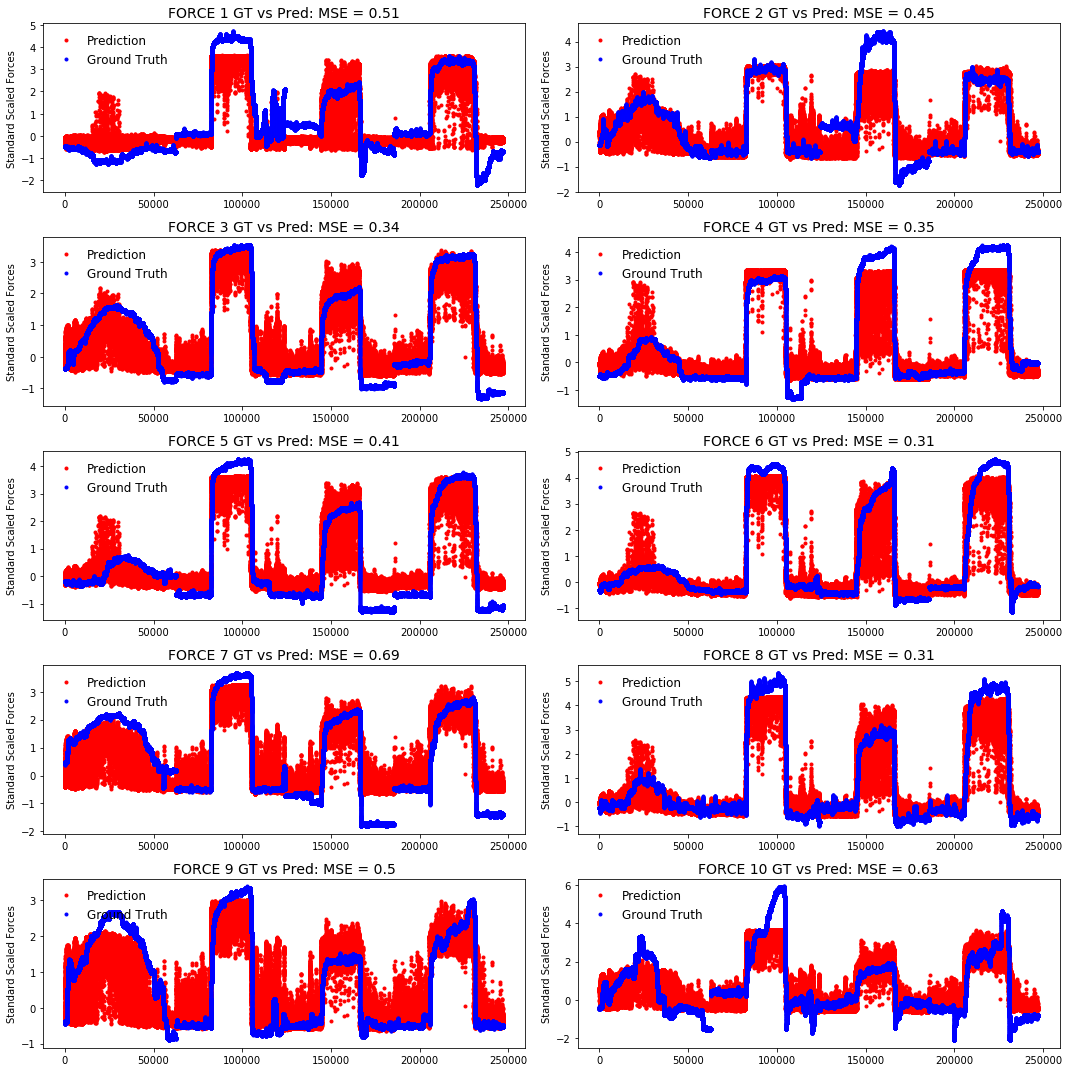

In [351]:
X3_, y3_ = X1.iloc[len(Xr_train):,:], y1.iloc[len(yr_train):,:]
plot_predict_res(RNN, X3_, y3_, n_samples=len(yr_test))

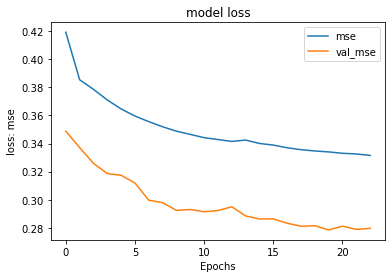

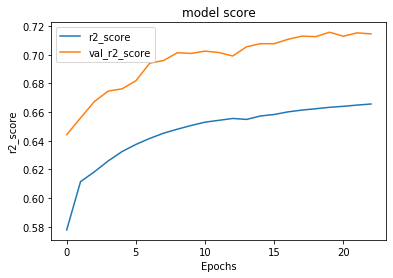

In [327]:
plot_model_evaluation(history, metric = 'mse', val_metric = 'val_mse')